<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for nonlinear regression

In this tutorial, we present the nonlinear regression utilities from the ``analysis`` module.

## Nonlinear regression

A synthetic data set is created and we perform nonlinear regression using kernel regression:

- [**Generating a synthetic data set**](#data-generation)
- [**Kernel regression**](#kernel-regression)
- [**Nonlinear regression assessment**](#assessment)
    - [**Visual assessment**](#assessment)
    - [**Streamplots for predicted vector quantities**](#streamplot)
    - [**Error metrics**](#error)
***

**Should plots be saved?**

In [1]:
save_plots = False

***

We import the necessary modules:

In [2]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
import numpy as np

and we set some initial parameters:

In [3]:
save_filename = None

<a id='data-generation'></a>
***

## Generating a synthetic data set

[**↑ Go to the top**](#top-page)

We begin by generating a synthetic data set with two independent variables, $x$ and $y$, and one dependent variable, $\phi$, that we will nonlinearly regress using kernel regression.

Generate independent variables $x$ and $y$ from a uniform grid:

In [4]:
n_points = 100
grid = np.linspace(0,100,n_points)
x, y = np.meshgrid(grid, grid)
x = x.flatten()
y = y.flatten()
xy = np.hstack((x[:,None],y[:,None]))
(n_observations, _) = np.shape(xy)

Generate a dependent variable $\phi$ as a linear function of $x$:

In [5]:
phi = xy[:,0:1]**2

Visualize the generated data set:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


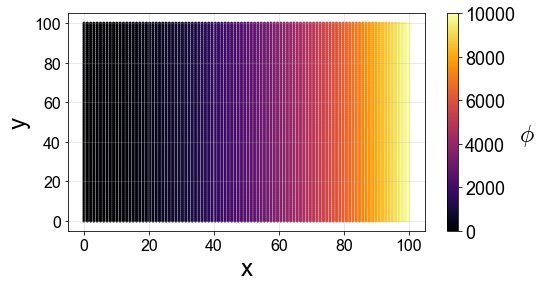

In [6]:
if save_plots: save_filename = '../images/tutorial-regression-data-set.svg'
plt = reduction.plot_2d_manifold(x, y, color=phi, x_label='x', y_label='y', colorbar_label='$\phi$', color_map='inferno', figure_size=(8,4), save_filename=save_filename)

<a id='kernel-regression'></a>
***

## Kernel regression

[**↑ Go to the top**](#top-page)

We first generate train and test samples using the `DataSampler` class:

In [7]:
train_perc = 80
random_seed = 100

idx = np.zeros((n_observations,)).astype(int)
sample_random = preprocess.DataSampler(idx, random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc, test_selection_option=1)

xy_train = xy[idx_train,:]
xy_test = xy[idx_test,:]

phi_train = phi[idx_train]
phi_test = phi[idx_test]

Specify the bandwidth for the Nadaraya-Watson kernel:

In [8]:
bandwidth = 10

Fit the kernel regression model with train data:

In [9]:
model = analysis.KReg(xy_train, phi_train)

Predict the test data:

In [10]:
phi_test_predicted = model.predict(xy_test, bandwidth=bandwidth)

Predict all data:

In [11]:
phi_predicted = model.predict(xy, bandwidth=bandwidth)

<a id='assessment'></a>
***

## Nonlinear regression assessment

[**↑ Go to the top**](#top-page)

In this section we will perform few assessments of the quality of the nonlinear regression.

### Visual assessment

We begin by visualizing the regressed (predicted) dependent variable $\phi$. This can be done either in 2D:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


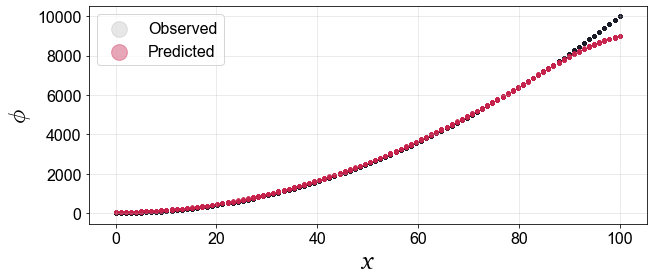

In [12]:
if save_plots: save_filename = '../images/tutorial-regression-result-2d.svg'
plt = analysis.plot_2d_regression(x, phi, phi_predicted, x_label='$x$', y_label='$\phi$', figure_size=(10,4), save_filename=save_filename)

or in 3D:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


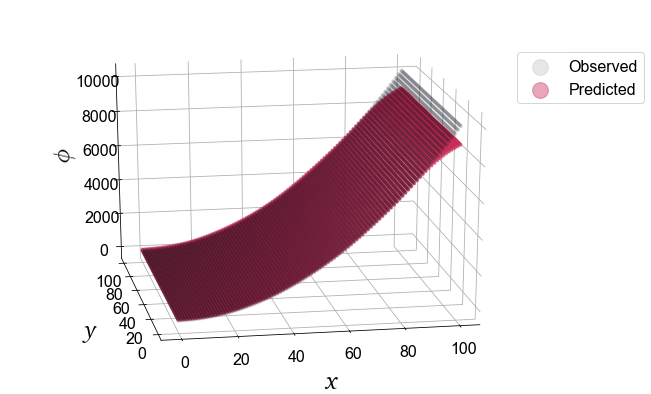

In [13]:
if save_plots: save_filename = '../images/tutorial-regression-result.svg'
plt = analysis.plot_3d_regression(x, y, phi, phi_predicted, elev=20, azim=-100, x_label='$x$', y_label='$y$', z_label='$\phi$', figure_size=(10,7), save_filename=save_filename)

We can then compute the coefficient of determination, $R^2$, values for the test data and entire data: 

In [14]:
r2_test = analysis.coefficient_of_determination(phi_test, phi_test_predicted)
r2_all = analysis.coefficient_of_determination(phi, phi_predicted)

print('All R2:\t\t' + str(round(r2_all, 6)) + '\nTest R2:\t' + str(round(r2_test, 6)))

All R2:		0.995841
Test R2:	0.996152


In addition to a single value of $R^2$ for the entire data set, we can also compute stratified $R^2$ values. This allows us to observe how kernel regression performed in each strata of the dependent variable $\phi$. We will compute the stratified $R^2$ in 20 bins of $\phi$:

In [15]:
n_bins = 20
use_global_mean = False
verbose = True

(r2_in_bins, bins_borders) = analysis.stratified_coefficient_of_determination(phi, phi_predicted, n_bins=n_bins, use_global_mean=use_global_mean, verbose=verbose)

Bin	1	| size	 2300	| R2	0.868336
Bin	2	| size	 900	| R2	0.870357
Bin	3	| size	 700	| R2	0.863821
Bin	4	| size	 600	| R2	0.880655
Bin	5	| size	 500	| R2	0.875764
Bin	6	| size	 500	| R2	0.889148
Bin	7	| size	 400	| R2	0.797888
Bin	8	| size	 400	| R2	0.773907
Bin	9	| size	 400	| R2	0.79479
Bin	10	| size	 400	| R2	0.862069
Bin	11	| size	 300	| R2	0.864022
Bin	12	| size	 300	| R2	0.93599
Bin	13	| size	 300	| R2	0.972185
Bin	14	| size	 300	| R2	0.988894
Bin	15	| size	 300	| R2	0.979975
Bin	16	| size	 300	| R2	0.766598
Bin	17	| size	 300	| R2	-0.46525
Bin	18	| size	 200	| R2	-11.158072
Bin	19	| size	 300	| R2	-10.94865
Bin	20	| size	 300	| R2	-28.00655


Finally, we can plot the stratified $R^2$ values across bins centers:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


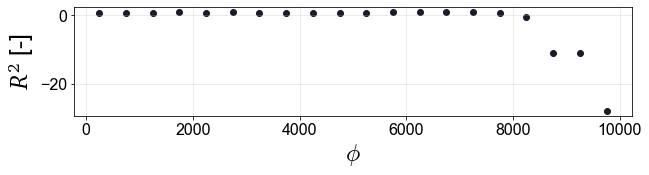

In [16]:
if save_plots: save_filename = '../images/tutorial-regression-stratified-r2.svg'
plt = analysis.plot_stratified_coefficient_of_determination(r2_in_bins, bins_borders, variable_name='$\phi$', figure_size=(10,2), save_filename=save_filename)

This last plot lets us see that kernel regression performed very well in the
middle range of the dependent variable values but very poorly at both edges of that range.
This is consistent with what we have seen in a 3D plot
that visualized the regression result.

<a id='streamplot'></a>

### Streamplots for predicted vector quantities

[**↑ Go to the top**](#top-page)

In a special case, when the predicted variable is a two-dimensional vector, a streamplot of the regressed vector field can be plotted using the function `plot_2d_regression_streamplot`.

Below, we show an example on a synthetic data set:

In [17]:
X = np.random.rand(100,5)
S_X = np.random.rand(100,5)

In [18]:
pca_X = reduction.PCA(X, n_components=2)
PCs = pca_X.transform(X)
S_Z = pca_X.transform(S_X, nocenter=True)

In [19]:
vector_model = analysis.KReg(PCs, S_Z)

We define the regression model function:

In [20]:
def regression_model(query):

    predicted = vector_model.predict(query, 'nearest_neighbors_isotropic', n_neighbors=1)

    return predicted

Define the bounds for the streamplot:

In [21]:
grid_bounds = ([np.min(PCs[:,0]),np.max(PCs[:,0])],[np.min(PCs[:,1]),np.max(PCs[:,1])])

Plot the regression streamplot:

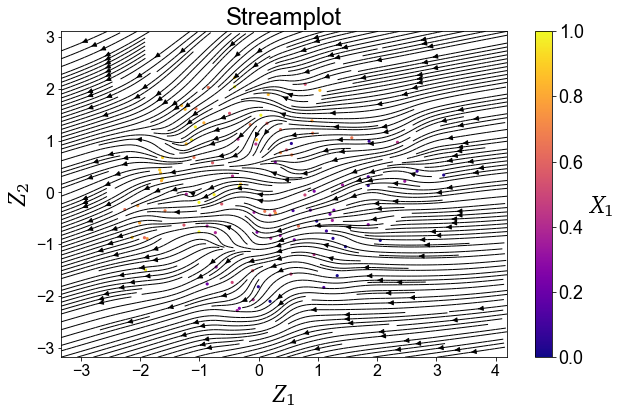

In [22]:
if save_plots: save_filename = '../images/tutorial-regression-streamplot.svg'
plt = analysis.plot_2d_regression_streamplot(grid_bounds,
                                    regression_model,
                                    x=PCs[:,0],
                                    y=PCs[:,1],
                                    resolution=(15,15),
                                    extension=(20,20),
                                    color='k',
                                    x_label='$Z_1$',
                                    y_label='$Z_2$',
                                    manifold_color=X[:,0],
                                    colorbar_label='$X_1$',
                                    color_map='plasma',
                                    colorbar_range=(0,1),
                                    manifold_alpha=1,
                                    grid_on=False,
                                    figure_size=(10,6),
                                    title='Streamplot',
                                    save_filename=save_filename)

<a id='error'></a>

### Error metrics

[**↑ Go to the top**](#top-page)

Finally, several error metrics are available that will measure how well the dependent variable(s) were predicted. Metrics can be accessed individually, those include:

- Mean absolute error
- Mean squared error
- Root mean squared error
- Normalized root mean squared error
- Turning points
- Good estimate
- Good direction estimate

An example of computing mean absolute error is shown below:

In [23]:
MAE = analysis.mean_absolute_error(phi, phi_predicted)
MAE

98.40068384195676

By instantiating an object of the `RegressionAssessment` class, one can compute all available metrics at once:

In [24]:
regression_metrics = analysis.RegressionAssessment(phi, phi_predicted, variable_names=['$\phi$'], norm='std')

As an example, mean absolute error can be accessed by:

In [25]:
regression_metrics.mean_absolute_error

array([[98.40068384]])

All computed metrics can be printed with the use of the `RegressionAssessment.print_metrics` function. Few output formats are available.

Raw text format:

In [26]:
regression_metrics.print_metrics(table_format=['raw'], float_format='%.4f')

--------------------
$\phi$
R2:	0.9958
MAE:	98.4007
MSE:	37762.8664
RMSE:	194.3267
NRMSE:	0.0645
GDE:	nan


`tex` format:

In [27]:
regression_metrics.print_metrics(table_format=['tex'], float_format='%.4f')


\begin{table}[h!]
\begin{center}
\begin{tabular}{ll} \toprule
 & \textit{$\phi$} \\ \midrule
$R^2$ & 0.9958 \\
MAE & 98.4007 \\
MSE & 37762.8664 \\
RMSE & 194.3267 \\
NRMSE & 0.0645 \\
GDE & nan \\
\end{tabular}
\caption{}\label{}
\end{center}
\end{table}



`pandas.DataFrame` format (most recommended for Jupyter notebooks):

In [28]:
regression_metrics.print_metrics(table_format=['pandas'], float_format='%.4f')

,$\phi$
$R^2$,0.9958
MAE,98.4007
MSE,"37,762.8664"
RMSE,194.3267
NRMSE,0.0645
GDE,nan


Note that with the `float_format` parameter you can change the number of digits displayed:

In [29]:
regression_metrics.print_metrics(table_format=['pandas'], float_format='%.2f')

,$\phi$
$R^2$,1.00
MAE,98.40
MSE,"37,762.87"
RMSE,194.33
NRMSE,0.06
GDE,nan


***